In [153]:
import matplotlib.pyplot as plt
import numpy as np
import mpltex
from scipy.optimize import minimize_scalar
import pint
import mwbr
ureg = pint.UnitRegistry()

In [15]:
def load_csv(filename):
    data = np.genfromtxt(filename, delimiter='\t')
    return data

In [206]:
q_data = []
for begin_val, end_val in zip([0, 25, 50, 75, 100, 125, 150], [30, 55, 80, 105, 130, 155, 180]):
    q_data.append(load_csv(f'./window_{begin_val}_{end_val}/qs_f_15.dat'))


In [207]:
# connect the last five with the first five between consecutive windows

offsets = []
for i in range(len(q_data)-1):
    q_left = q_data[i]
    q_right = q_data[i+1]

    mean_left = np.mean(q_left[-5:,1])
    mean_right = np.mean(q_right[:5,1])
    print(mean_left, mean_right)

    offsets.append(mean_right - mean_left + (offsets[-1] if offsets else 0))



3740.102 3468.844
3742.9440000000004 3544.5379999999996
3825.964 3608.308
3898.218 4894.268
5190.174 10148.899999999998
10438.779999999999 21259.159999999996


In [208]:
# define a function for the l2 norm of the difference between the last five of one array
# and the first five of the next array
def l2_norm(q_left, q_right):
    return np.linalg.norm(q_left[-6:,1] - q_right[:6,1])

# function which optimizes the offset of array 2 to array 1 such that the l2 norm is minimized
def optimize_offset(q_left, q_right):
    # define a function which returns the l2 norm for a given offset
    def f(offset):
        return l2_norm(q_left, q_right + offset)

    # find the minimum of the function
    res = minimize_scalar(f)
    return res.x

offsets = []
concatenate_n = q_data[0][:,0]
concatenate_q = q_data[0][:,1]
for i in range(len(q_data)-1):
    q_left = q_data[i]
    q_right = q_data[i+1]

    # determine the offset which minimizes the l2 norm
    offset = optimize_offset(q_left, q_right)
    print(offset)
    total_offset = offset + (offsets[-1] if offsets else 0)
    offsets.append(total_offset)

    concatenate_n = np.concatenate([concatenate_n, q_right[5:,0]])
    concatenate_q = np.concatenate([concatenate_q, q_right[5:,1]+total_offset])
    # mean_profile = np.mean([q_left[-6:, 1], q_right[:6, 1]+total_offset], axis=0)

    # concatenate_q = np.concatenate([concatenate_q, mean_profile, q_right[5:,1]+total_offset])
    # concatenate_n = np.concatenate([concatenate_n, q_left[-6:,0], q_right[5:,0]])


260.8200002116574
187.72833321705548
206.66833395155578
-1007.3416664593766
-4970.059998600946
-10831.016667506328


In [209]:
alex_qs = np.loadtxt('./AlexQs.dat')

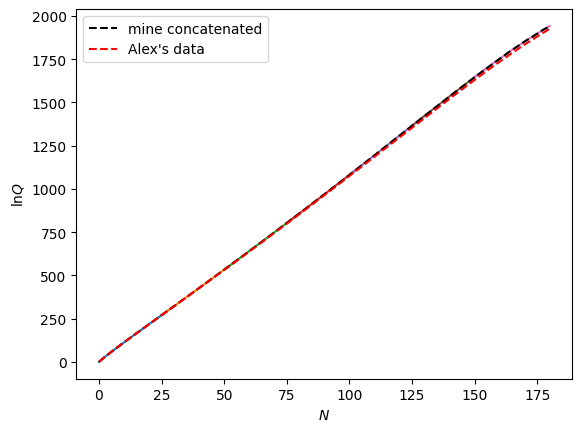

In [237]:
fig, ax = plt.subplots()
zero = q_data[0][0,1]

plt.plot(q_data[0][:,0], -zero+q_data[0][:,1])
offsets_p = offsets.copy()
for window in q_data[1:]:
    plt.plot(window[:,0], -zero+window[:,1]+offsets_p.pop(0))

# plt.xlabel('$N$')
# plt.ylabel('$\ln Q$')
plt.plot(concatenate_n, -zero+concatenate_q, '--', color='black', label='Mine concatenated')
plt.plot(alex_qs[:,0], alex_qs[:,1]-alex_qs[0,1], '--', color='red', label='Alex\'s data')

plt.legend()
plt.xlabel('$N$')
plt.ylabel('$\ln Q$')

plt.show()

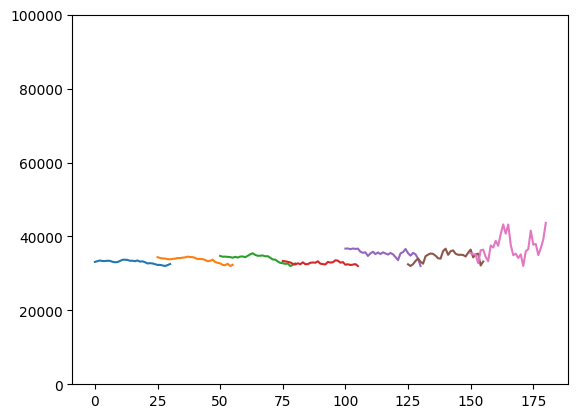

In [211]:
fig, ax = plt.subplots()
zero = q_data[0][0,1]

plt.plot(q_data[0][:,0], q_data[0][:,2])
for window in q_data[1:]:
    plt.plot(window[:,0], +window[:,2])

# plt.xlabel('$N$')
# plt.ylabel('$\ln Q$')
plt.ylim((0, 1e5))
plt.show()

## Grand Potential

In [233]:
N = concatenate_n
lnq = concatenate_q
epsilon = 0.1892*ureg.kcal/ureg.mol
sigma = 3.75*ureg.angstrom
mass = 28.0*ureg.atomic_mass_constant
T = 95.21 * ureg.kelvin
ureg.define(f'epsilon = {epsilon}')
ureg.define(f'sigma = {sigma}')
ureg.define(f'mass = {mass}')

#fugacity = 1.5e10*ureg.bar
fugacity = 6.0*ureg.bar

db = ureg.planck_constant / np.sqrt(2*np.pi * mass * ureg.boltzmann_constant * T)
mu = ureg.boltzmann_constant*T * np.log((fugacity)*db**3/(ureg.boltzmann_constant*T))

omega = -1*ureg.boltzmann_constant*T*(lnq-lnq[0]) - mu*N
mu_kelvin = mu/ureg.boltzmann_constant

/home/pstaerk/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


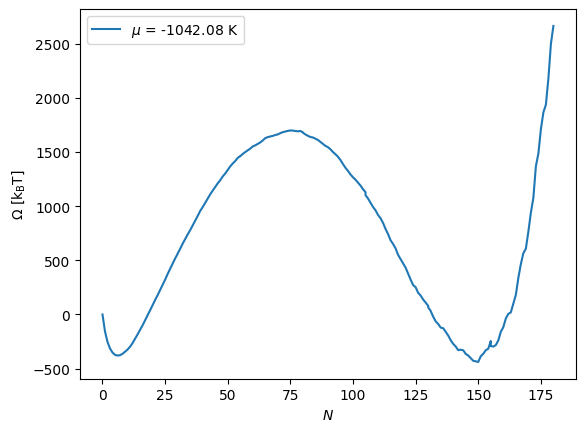

In [235]:
plt.plot(N, omega, label=f'$\mu$ = {mu_kelvin.magnitude:.2f} K')
plt.xlabel('$N$')
plt.ylabel('$\Omega$ [k$_{\mathrm{B}}$T]')
plt.legend()
plt.show()

## Check with PyMWBR

Alex EOS for LJ fluids:

In [164]:
epsilon_lj = epsilon.to('boltzmann_constant * kelvin/ molecule').magnitude
sigma_lj = sigma.to('nanometer').magnitude
mass_lj = mass.magnitude

In [225]:
eos = mwbr.MBWR(rcut=4., sigma=sigma_lj, epsilon=epsilon_lj, mass=mass_lj)

res = eos.fsat(1.)/eos.to_lj_p

/home/pstaerk/Documents/Uni/PhD/binaries/lammps_develop/examples/mc/n2/mwbr.py:201: RuntimeWarning: divide by zero encountered in divide
  return self.Ar(rho,T) + P/rho + T*np.log(rho*self.deBroglie(T)**3)
/home/pstaerk/Documents/Uni/PhD/binaries/lammps_develop/examples/mc/n2/mwbr.py:201: RuntimeWarning: divide by zero encountered in log
  return self.Ar(rho,T) + P/rho + T*np.log(rho*self.deBroglie(T)**3)
/home/pstaerk/Documents/Uni/PhD/binaries/lammps_develop/examples/mc/n2/mwbr.py:201: RuntimeWarning: invalid value encountered in add
  return self.Ar(rho,T) + P/rho + T*np.log(rho*self.deBroglie(T)**3)
/home/pstaerk/Documents/Uni/PhD/binaries/lammps_develop/examples/mc/n2/mwbr.py:319: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one wil